In [1]:
import os, sys
import pandas as pd
import numpy as np
import datetime as dt
from pprint import pprint
import csv
import itertools as it
from prettytable import PrettyTable
import matplotlib.pylab as plt
import seaborn as sns
import portion as P
from collections import namedtuple
import math

pdir = os.path.abspath(os.path.join(os.getcwd(), '..'))  # for jupyter-notebook
sys.path.insert(1, pdir)
from myutils import *

%config InlineBackend.figure_format = 'retina'  # 提高 jupyter notebook 的圖形顯示解析度
# plt.style.use('ggplot')
pd.set_option('display.max_columns', 200)
# pd.set_option('display.max_rows', 200)

DataFrame = namedtuple('DataFrame', 'filename, df', defaults=tuple([None]*2))

def set_data(df, mode='pcap', tz=0):
    if mode == 'pcap':
        df['seq'] = df['seq'].astype('Int32')
        # df['rpkg'] = df['rpkg'].astype('Int8')
        df['frame_id'] = df['frame_id'].astype('Int32')
        df['Timestamp'] = pd.to_datetime(df['Timestamp'])
        df['xmit_time'] = pd.to_datetime(df['xmit_time'])
        df['arr_time'] = pd.to_datetime(df['arr_time'])
        df['Timestamp_epoch'] = df['Timestamp_epoch'].astype('float32')
        df['xmit_time_epoch'] = df['xmit_time_epoch'].astype('float32')
        df['arr_time_epoch'] = df['arr_time_epoch'].astype('float32')
        df['lost'] = df['lost'].astype('boolean')
        df['excl'] = df['excl'].astype('boolean')
        df['latency'] = df['latency'].astype('float32')
    # E-UTRA & NR
    def nr_serv_cel(row):
        pos = row.serv_cel_pos
        if pos == 255:
            return 65535, -160, -50
        else:
            return row[f'PCI{pos}'], row[f'RSRP{pos}'], row[f'RSRQ{pos}']
    if mode == 'lte':
        df = df.rename(columns={
            'RSRP(dBm)': 'RSRP',
            'RSRQ(dB)': 'RSRQ',
            'Serving Cell Index': 'serv_cel_index',
            'Number of Neighbor Cells': 'num_neigh_cels',
            'Number of Detected Cells': 'num_cels',
            }).reindex(['Timestamp','type_id','PCI','RSRP','RSRQ','serv_cel_index','EARFCN','NR_ARFCN',
                        'num_cels','num_neigh_cels','serv_cel_pos','PCI0','RSRP0','RSRQ0',
                        *df.columns.to_list()[df.columns.get_loc('PCI1'):]], axis=1)
        df.loc[df['serv_cel_index'] == '(MI)Unknown', 'serv_cel_index'] = '3_SCell'
        df['num_cels'] = df['num_neigh_cels'] + 1
        ## set dtypes
        df['Timestamp'] = pd.to_datetime(df['Timestamp']) + pd.Timedelta(hours=tz)
        df['type_id'] = df['type_id'].astype('category')
        df['serv_cel_index'] = df['serv_cel_index'].astype('category')
        df['EARFCN'] = df['EARFCN'].astype('Int32')
        df['NR_ARFCN'] = df['NR_ARFCN'].astype('Int32')
        df['num_cels'] = df['num_cels'].astype('UInt8')
        df['num_neigh_cels'] = df['num_neigh_cels'].astype('UInt8')
        df['serv_cel_pos'] = df['serv_cel_pos'].astype('UInt8')
        for tag in df.columns:
            if tag.startswith('PCI'):
                df[tag] = df[tag].astype('Int32')
            if tag.startswith(('RSRP','RSRQ')):
                df[tag] = df[tag].astype('float32')
    if mode == 'nr':
        if df.empty:
            df = pd.DataFrame(columns=['Timestamp','type_id','PCI','RSRP','RSRQ','serv_cel_index','EARFCN','NR_ARFCN',
                                       'num_cels','num_neigh_cels','serv_cel_pos','PCI0','RSRP0','RSRQ0'])
        else:
            df = df.rename(columns={
                'Raster ARFCN': 'NR_ARFCN',
                'Serving Cell Index': 'serv_cel_pos',
                'Num Cells': 'num_cels',
                }).reindex(['Timestamp','type_id','PCI','RSRP','RSRQ','serv_cel_index','EARFCN','NR_ARFCN',
                            'num_cels','num_neigh_cels','serv_cel_pos','PCI0','RSRP0','RSRQ0',
                            *df.columns.to_list()[df.columns.get_loc('PCI1'):]], axis=1)
            df.loc[df['serv_cel_pos'] != 255, 'serv_cel_index'] = 'PSCell'
            df[['PCI','RSRP','RSRQ']] = df.apply(nr_serv_cel, axis=1, result_type='expand')
            df.loc[df['serv_cel_pos'] == 255, 'num_neigh_cels'] = df['num_cels']
            df.loc[df['serv_cel_pos'] != 255, 'num_neigh_cels'] = df['num_cels'] - 1
        ## set dtypes
        df['Timestamp'] = pd.to_datetime(df['Timestamp']) + pd.Timedelta(hours=tz)
        df['type_id'] = df['type_id'].astype('category')
        df['serv_cel_index'] = df['serv_cel_index'].astype('category')
        df['EARFCN'] = df['EARFCN'].astype('Int32')
        df['NR_ARFCN'] = df['NR_ARFCN'].astype('Int32')
        df['num_cels'] = df['num_cels'].astype('UInt8')
        df['num_neigh_cels'] = df['num_neigh_cels'].astype('UInt8')
        df['serv_cel_pos'] = df['serv_cel_pos'].astype('UInt8')
        for tag in df.columns:
            if tag.startswith('PCI'):
                df[tag] = df[tag].astype('Int32')
            if tag.startswith(('RSRP','RSRQ')):
                df[tag] = df[tag].astype('float32')
    return df

In [2]:
datadir = "/Users/jackbedford/Desktop/MOXA/Code/data"
exps = {
    'All': [("2023-05-07/_Bandlock_8_Schemes_Phone/sm00", ["#{:02d}".format(i+1) for i in range(4)]),],
    'B3':  [("2023-05-07/_Bandlock_8_Schemes_Phone/sm01", ["#{:02d}".format(i+1) for i in range(4)]),],
    'B7':  [("2023-05-07/_Bandlock_8_Schemes_Phone/sm02", ["#{:02d}".format(i+1) for i in range(4)]),],
    'B8':  [("2023-05-07/_Bandlock_8_Schemes_Phone/sm03", ["#{:02d}".format(i+1) for i in range(4)]),],
    'B3B7':[("2023-05-07/_Bandlock_8_Schemes_Phone/sm04", ["#{:02d}".format(i+1) for i in range(4)]),],
    'B3B8':[("2023-05-07/_Bandlock_8_Schemes_Phone/sm05", ["#{:02d}".format(i+1) for i in range(4)]),],
    'B7B8':[("2023-05-07/_Bandlock_8_Schemes_Phone/sm06", ["#{:02d}".format(i+1) for i in range(4)]),],
    'LTE': [("2023-05-07/_Bandlock_8_Schemes_Phone/sm07", ["#{:02d}".format(i+1) for i in range(4)]),],
}

In [3]:
DD = {
    'All': [0, [], []],
    'B3': [0, [], []],
    'B7': [0, [], []],
    'B8': [0, [], []],
    'B3B7': [0, [], []],
    'B3B8': [0, [], []],
    'B7B8': [0, [], []],
    'LTE': [0, [], []],
}
Overall = [0, [], []]

for key, item in exps.items():
    print(key)
    for exp in item:
        for trace in exp[1]:
            ## read uplink
            data = os.path.join(datadir, exp[0], trace, 'data', 'udp_uplk_loss_latency.csv')
            print(data, os.path.isfile(data))
            df_ul = pd.read_csv(data)
            df_ul = set_data(df_ul)
            ulplr = df_ul.lost.mean() * 100
            print(ulplr)
            ## read downlink
            data = os.path.join(datadir, exp[0], trace, 'data', 'udp_dnlk_loss_latency.csv')
            print(data, os.path.isfile(data))
            df_dl = pd.read_csv(data)
            df_dl = set_data(df_dl)
            dlplr = df_dl.lost.mean() * 100
            print(dlplr)
            # fill in
            DD[key][0] += 1
            DD[key][1].append(ulplr)
            DD[key][2].append(dlplr)
            Overall[0] += 1
            Overall[1].append(ulplr)
            Overall[2].append(dlplr)

pprint(DD)
print(Overall)

All
/Users/jackbedford/Desktop/MOXA/Code/data/2023-05-07/_Bandlock_8_Schemes_Phone/sm00/#01/data/udp_uplk_loss_latency.csv True
0.05603369576851158
/Users/jackbedford/Desktop/MOXA/Code/data/2023-05-07/_Bandlock_8_Schemes_Phone/sm00/#01/data/udp_dnlk_loss_latency.csv True
0.9204636316130779
/Users/jackbedford/Desktop/MOXA/Code/data/2023-05-07/_Bandlock_8_Schemes_Phone/sm00/#02/data/udp_uplk_loss_latency.csv True
0.05278625845293463
/Users/jackbedford/Desktop/MOXA/Code/data/2023-05-07/_Bandlock_8_Schemes_Phone/sm00/#02/data/udp_dnlk_loss_latency.csv True
1.1227779838502583
/Users/jackbedford/Desktop/MOXA/Code/data/2023-05-07/_Bandlock_8_Schemes_Phone/sm00/#03/data/udp_uplk_loss_latency.csv True
0.12366973671363948
/Users/jackbedford/Desktop/MOXA/Code/data/2023-05-07/_Bandlock_8_Schemes_Phone/sm00/#03/data/udp_dnlk_loss_latency.csv True
0.24799036677840336
/Users/jackbedford/Desktop/MOXA/Code/data/2023-05-07/_Bandlock_8_Schemes_Phone/sm00/#04/data/udp_uplk_loss_latency.csv True
0.02203022

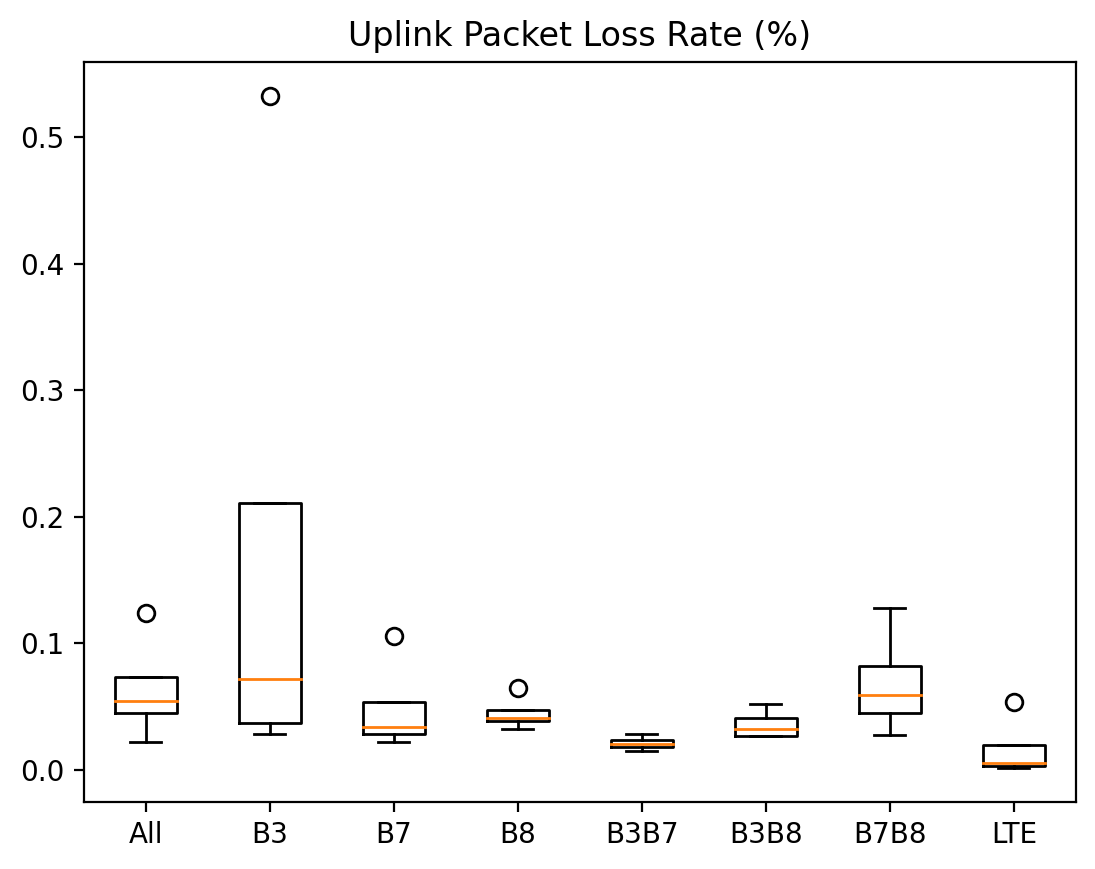

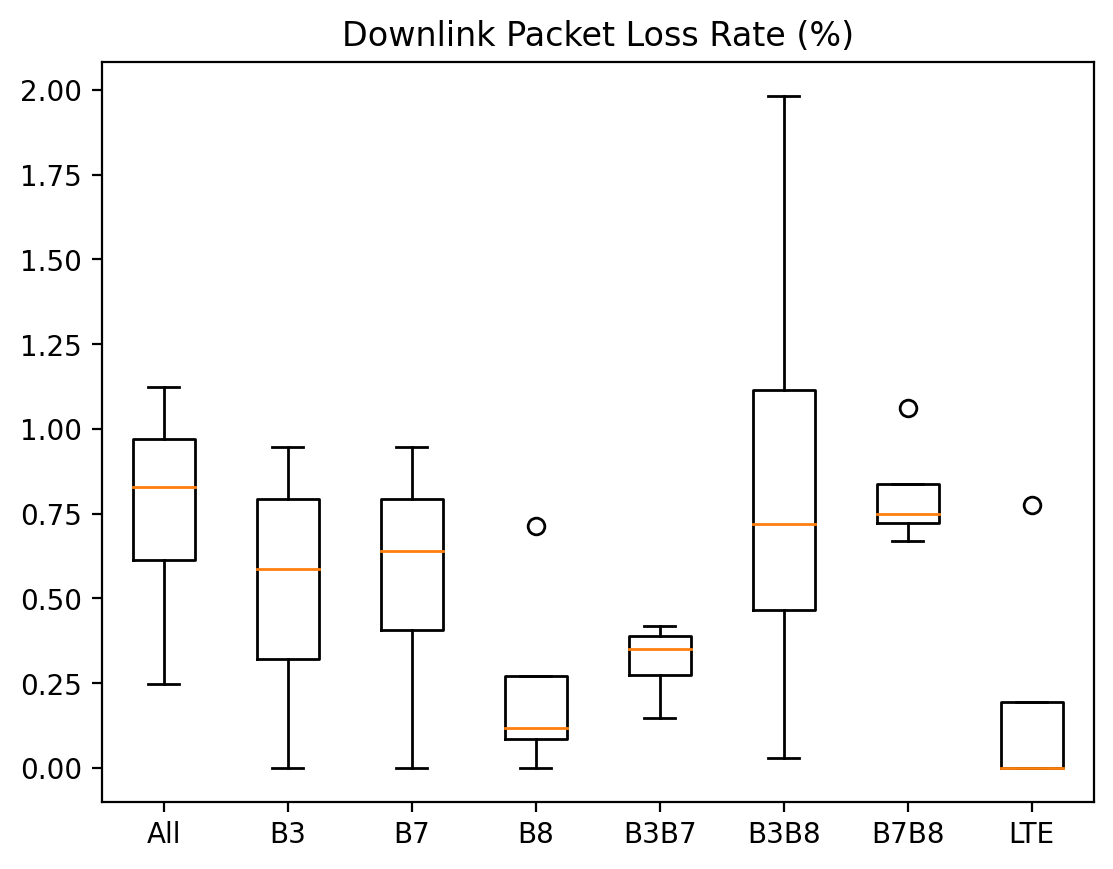

In [11]:
### Uplink
boxes = [DD['All'][1], DD['B3'][1], DD['B7'][1], DD['B8'][1], DD['B3B7'][1], DD['B3B8'][1], DD['B7B8'][1], DD['LTE'][1]]
labels = 'All', 'B3', 'B7', 'B8', 'B3B7', 'B3B8', 'B7B8', 'LTE'
plt.figure()
plt.boxplot(boxes, labels=labels, showfliers=True)
# plt.violinplot(boxes, labels=labels, showfliers=False)
plt.title('Uplink Packet Loss Rate (%)')
plt.show()

### Downlink
boxes = [DD['All'][2], DD['B3'][2], DD['B7'][2], DD['B8'][2], DD['B3B7'][2], DD['B3B8'][2], DD['B7B8'][2], DD['LTE'][2]]
labels = 'All', 'B3', 'B7', 'B8', 'B3B7', 'B3B8', 'B7B8', 'LTE'
plt.figure()
plt.boxplot(boxes, labels=labels, showfliers=True)
# plt.violinplot(boxes, labels=labels, showfliers=False)
plt.title('Downlink Packet Loss Rate (%)')
plt.show()

In [12]:
ul_plrs = sorted(Overall[1])
ul_upper_thr = np.percentile(ul_plrs, 75)
ul_lower_thr = np.percentile(ul_plrs, 25)
print(ul_upper_thr, ul_lower_thr)

dl_plrs = sorted(Overall[2])
dl_upper_thr = np.percentile(dl_plrs, 75)
dl_lower_thr = np.percentile(dl_plrs, 25)
print(dl_upper_thr, dl_lower_thr)

0.05414921580189014 0.02530240259779617
0.765613304260097 0.12195486541138784


In [38]:
table_ul = pd.DataFrame(columns=[0, 1, 2, 3, 4])
table_dl = pd.DataFrame(columns=[0, 1, 2, 3, 4])
table_ul_plr = pd.DataFrame(columns=[0, 1, 2, 3, 4])
table_dl_plr = pd.DataFrame(columns=[0, 1, 2, 3, 4])
for key in ['All', 'B3', 'B7', 'B8', 'B3B7', 'B3B8', 'B7B8', 'LTE']:
    row_ul = [key, *['O' if s < ul_lower_thr else 'X' if s > ul_upper_thr else '∆' for s in DD[key][1]]]
    row_dl = [key, *['O' if s < dl_lower_thr else 'X' if s > dl_upper_thr else '∆' for s in DD[key][2]]]
    table_ul.loc[len(table_ul)] = row_ul
    table_dl.loc[len(table_dl)] = row_dl
    table_ul_plr.loc[len(table_ul_plr)] = [key, *DD[key][1]]
    table_dl_plr.loc[len(table_dl_plr)] = [key, *DD[key][2]]

table_ul = table_ul.set_index(0).T
table_dl = table_dl.set_index(0).T
table_ul_plr = table_ul_plr.set_index(0).T
table_dl_plr = table_dl_plr.set_index(0).T

In [39]:
print('Uplink PLR')
display(table_ul)
display(table_ul_plr)

print('Downlink PLR')
display(table_dl)
display(table_dl_plr)

Uplink PLR


,All,B3,B7,B8,B3B7,B3B8,B7B8,LTE
1,X,X,∆,∆,O,∆,X,∆
2,∆,∆,∆,∆,O,∆,X,O
3,X,X,O,X,O,∆,∆,O
4,O,∆,X,∆,∆,∆,∆,O


,All,B3,B7,B8,B3B7,B3B8,B7B8,LTE
1,0.056034,0.103265,0.036520,0.040909,0.018883,0.051623,0.127809,0.053521
2,0.052786,0.039946,0.030673,0.040660,0.014980,0.026393,0.067053,0.002853
3,0.123670,0.532431,0.021479,0.064438,0.021479,0.026687,0.027338,0.001302
4,0.022030,0.028226,0.105332,0.032357,0.028226,0.037176,0.050945,0.008261


Downlink PLR


,All,B3,B7,B8,B3B7,B3B8,B7B8,LTE
1,X,∆,X,∆,∆,X,X,O
2,X,∆,∆,O,∆,X,∆,O
3,∆,X,O,∆,∆,O,∆,X
4,∆,O,∆,O,∆,∆,∆,O


,All,B3,B7,B8,B3B7,B3B8,B7B8,LTE
1,0.920464,0.428801,0.947823,0.713076,0.317866,0.824709,1.060876,0.000000
2,1.122778,0.744001,0.542129,0.000713,0.381630,1.982338,0.669815,0.000000
3,0.247990,0.947050,0.000000,0.124972,0.417874,0.029941,0.762196,0.775865
4,0.735947,0.000000,0.740078,0.112905,0.147327,0.612027,0.738701,0.000000
